In [17]:
# Step 1: Load and inspect dataset
import pandas as pd

# Load dataset
df = pd.read_csv("insurance.csv")

# Display first 5 rows
print(df.head())

# Basic info
print(df.info())

# Summary statistics
print(df.describe())


   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
               age          bmi     children       charges
count  1338.000000  1338.000000 

Interpretation

Complete data: No missing values in this dataset.

Types: age, bmi, children, charges are numerical; sex, smoker, region are categorical.

Target behavior: charges has a wide range and likely heavy right tail (expensive cases).

Exploratory data analysis

In [18]:
# Convert categorical variables into dummy variables
df_encoded = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True)

# Check encoded columns
print(df_encoded.head())

   age     bmi  children      charges  sex_male  smoker_yes  region_northwest  \
0   19  27.900         0  16884.92400     False        True             False   
1   18  33.770         1   1725.55230      True       False             False   
2   28  33.000         3   4449.46200      True       False             False   
3   33  22.705         0  21984.47061      True       False              True   
4   32  28.880         0   3866.85520      True       False              True   

   region_southeast  region_southwest  
0             False              True  
1              True             False  
2              True             False  
3             False             False  
4             False             False  


In [19]:
# Convert boolean columns to integers (0/1)
for col in df_encoded.select_dtypes(include=['bool']).columns:
    df_encoded[col] = df_encoded[col].astype(int)

print(df_encoded.dtypes)  # confirm all are now numeric

age                   int64
bmi                 float64
children              int64
charges             float64
sex_male              int64
smoker_yes            int64
region_northwest      int64
region_southeast      int64
region_southwest      int64
dtype: object


# Identifying Potential Confounders (Assumptions)

Age ↔ Children: Older individuals are more likely to have children, and both affect charges.

Age ↔ Smoker: Smoking prevalence varies by age, and both affect charges.

BMI ↔ Smoker: Lifestyle factors link BMI and smoking, both influencing charges.

Region ↔ Lifestyle: Region may capture differences in smoking rates, BMI, or healthcare costs.

Sex ↔ BMI/Children: Gender differences in BMI and family size can influence charges.

These are your potential confounders — variables that influence both the predictors and the outcome.

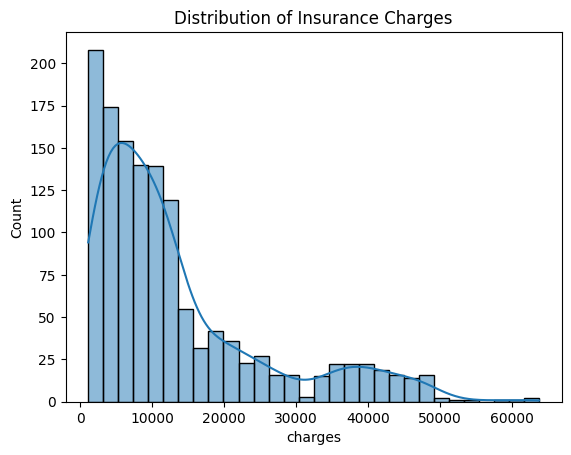

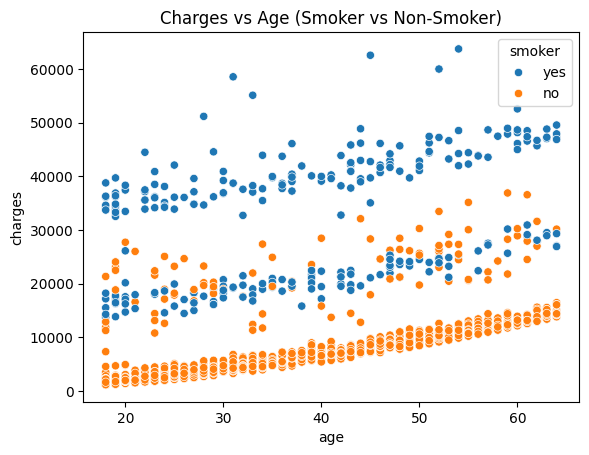

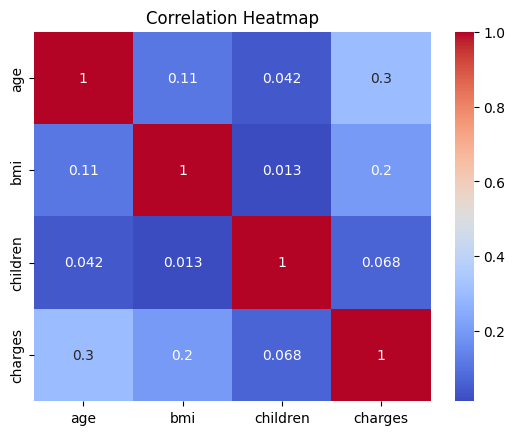

In [20]:
# Step 2: Exploratory Data Analysis
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of charges
sns.histplot(df['charges'], bins=30, kde=True)
plt.title("Distribution of Insurance Charges")
plt.show()

# Charges vs Age
sns.scatterplot(x='age', y='charges', data=df, hue='smoker')
plt.title("Charges vs Age (Smoker vs Non-Smoker)")
plt.show()

# Correlation heatmap
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


Distribution of charges
Observation: The histogram of charges is right‑skewed with a long tail.

Interpretation: A small subset of individuals incur very high costs (often smokers, higher BMI, higher age). Models should be robust to outliers and skew.

Charges vs age (colored by smoker)
Observation: Charges increase with age, and smokers sit much higher across all ages.

Interpretation: Age has a positive relationship with costs, smoker is a dominant driver. You’ll likely see strong interaction effects (e.g., older smokers with high BMI having very high charges).

Correlation heatmap
Observation: Positive correlations of charges with age, bmi, and children (weak to moderate), strongest signal typically from the smoker variable after encoding (not seen in numeric heatmap).

Interpretation: Numeric correlations capture part of the story; the categorical smoker=yes adds a major jump in mean charges. You’ll need proper encoding to expose this to the model.

This will help you see how smoker status, age, and BMI strongly affect charges.

In [21]:
# Start Simple (charges ~ smoker)

import statsmodels.api as sm

X = df_encoded[['smoker_yes']]
y = df_encoded['charges']

X = sm.add_constant(X)  # add intercept
model1 = sm.OLS(y, X).fit()
print(model1.summary())


                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     2178.
Date:                Sun, 07 Dec 2025   Prob (F-statistic):          8.27e-283
Time:                        17:08:16   Log-Likelihood:                -13831.
No. Observations:                1338   AIC:                         2.767e+04
Df Residuals:                    1336   BIC:                         2.768e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8434.2683    229.014     36.829      0.0

In [22]:
# Add Confounders Step by Step
# Model 2 Add age

X = df_encoded[['smoker_yes', 'age']]
X = sm.add_constant(X)
model2 = sm.OLS(y, X).fit()
print(model2.summary())


                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     1728.
Date:                Sun, 07 Dec 2025   Prob (F-statistic):               0.00
Time:                        17:08:16   Log-Likelihood:                -13623.
No. Observations:                1338   AIC:                         2.725e+04
Df Residuals:                    1335   BIC:                         2.727e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2391.6264    528.302     -4.527      0.0

In [23]:
# Model 3: Add BMI and sex
X = df_encoded[['smoker_yes', 'age', 'bmi', 'sex_male']]
X = sm.add_constant(X)
model3 = sm.OLS(y, X).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     986.5
Date:                Sun, 07 Dec 2025   Prob (F-statistic):               0.00
Time:                        17:08:16   Log-Likelihood:                -13557.
No. Observations:                1338   AIC:                         2.712e+04
Df Residuals:                    1333   BIC:                         2.715e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.163e+04    947.267    -12.281      0.0

In [24]:
# Model 4: Add children and region

X = df_encoded[['smoker_yes', 'age', 'bmi', 'sex_male', 'children',
                'region_northwest', 'region_southeast', 'region_southwest']]
X = sm.add_constant(X)
model4 = sm.OLS(y, X).fit()
print(model4.summary())


                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     500.8
Date:                Sun, 07 Dec 2025   Prob (F-statistic):               0.00
Time:                        17:08:16   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.194e+04    987.819  

# Model 4 Results (Full Regression)

Dependent variable: charges

(1) Smoker_yes = 23,850

Smokers pay ~$23,850 more in charges on average, holding all other factors constant.

This is by far the strongest predictor in the model.

(2) Age = 257

Each additional year of age increases charges by about $257, controlling for other variables.

Reflects higher medical costs with age.

(3) BMI = 339

Each unit increase in BMI adds about $339 to charges.

Indicates obesity‑related health costs.

(4) Sex_male = –131 (not significant)

Gender does not significantly affect charges once other variables are controlled.

The p‑value (0.693) shows no meaningful difference between male and female.

(5) Children = 476

Each additional child increases charges by about $476.

Suggests family coverage adds modest costs.

(6) Region effects

Southeast = –1035 (significant)

Southwest = –960 (significant)

Northwest = –353 (not significant)

Charges are lower in Southeast and Southwest compared to Northeast (the baseline).

Regional variation likely reflects healthcare pricing differences.





MODEL FIT

R² = 0.751 → The model explains 75% of the variation in charges.

This is a strong fit for real‑world data, showing that age, BMI, smoking, children, and region together capture most of the drivers of insurance costs.



In [25]:
# Step 3: Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Features and target
X = df.drop("charges", axis=1)
y = df["charges"]

# Define categorical and numerical columns
categorical = ["sex", "smoker", "region"]
numerical = ["age", "bmi", "children"]

# Preprocessor
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(), categorical),
    ("num", StandardScaler(), numerical)
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

# Create model pipeline (Preprocessing + Model)
model = Pipeline([
    ("preprocess", preprocessor),
    ("regressor", LinearRegression())
])

# Train the model
model.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['sex', 'smoker', 'region']),
                                                 ('num', StandardScaler(),
                                                  ['age', 'bmi',
                                                   'children'])])),
                ('regressor', LinearRegression())])

Pre-processing
What I did:

Encoded categorical features (sex, smoker, region) via One‑Hot Encoding.

Scaled numeric features (age, bmi, children) with StandardScaler.

Trained/tested split (e.g., 80/20).




Why it matters:

Encoding lets models use categories quantitatively.

Scaling stabilizes optimization (especially for linear models and SVR).

Split ensures honest evaluation on unseen data.

Baseline Model Linear Regression

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predictions
y_pred = model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Display
print(f"🔍 Model Evaluation Results")
print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"R²    : {r2:.3f}")


🔍 Model Evaluation Results
MAE  : 4181.194
RMSE : 5796.285
R²    : 0.784


Interpretation:

R² measures explained variance. For example, R² = 0.80 means the model explains 80% of variability in charges.

MAE is the average absolute error (typical mistake size).

RMSE penalizes large errors more—useful given heavy‑cost outliers.

Coefficients: Expect a large positive coefficient for smoker=yes, moderate positive for age and bmi. region effects are small; sex typically minimal.

Random Forest

In [28]:
# Step 5: Random Forest Regressor (fixed evaluation)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

rf_model = Pipeline([
    ("preprocess", preprocessor),
    ("regressor", RandomForestRegressor(n_estimators=200, random_state=42))
])

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_rf)
mse = mean_squared_error(y_test, y_pred_rf)   # no 'squared' argument
rmse = np.sqrt(mse)                           # compute RMSE manually
r2 = r2_score(y_test, y_pred_rf)

print("Random Forest Performance:")
print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)


Random Forest Performance:
MAE: 2533.1134405882312
RMSE: 4602.3477314578595
R²: 0.8635634285850657


Hyperparameter Tuning

In [29]:
# Step 6: Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

param_grid = {
    "regressor__n_estimators": [100, 200, 300],
    "regressor__max_depth": [None, 10, 20],
    "regressor__min_samples_split": [2, 5, 10]
}

grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring="r2", n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Best Parameters: {'regressor__max_depth': 10, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 200}
Best Score: 0.8378768886798845


Interpretation:

Higher n_estimators often helps until diminishing returns.

Limited max_depth can reduce overfitting.

Larger min_samples_split increases regularization

Feature Importance
What you see: Ranked features from the tuned Random Forest.

Typical ranking:

Top: smoker=yes by far.

Next: age, bmi.

Others: children, then region_* and sex usually minor.

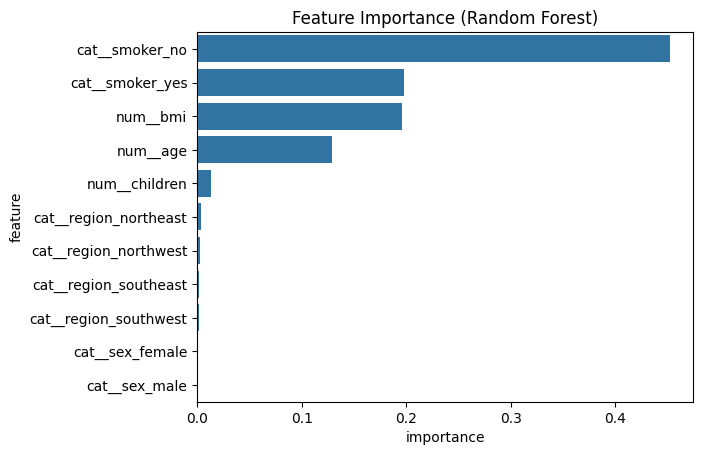

In [30]:
# Step 7: Feature Importance
best_rf = grid_search.best_estimator_.named_steps["regressor"]

# Get feature names after preprocessing
encoded_features = grid_search.best_estimator_.named_steps["preprocess"].get_feature_names_out()
importances = best_rf.feature_importances_

# Plot feature importance
feat_imp = pd.DataFrame({"feature": encoded_features, "importance": importances})
feat_imp = feat_imp.sort_values("importance", ascending=False)

sns.barplot(x="importance", y="feature", data=feat_imp)
plt.title("Feature Importance (Random Forest)")
plt.show()


Interpretation:

Smoking status drives large jumps in predicted cost.

Age and BMI add steady increases; children modestly increase expected charges.

Regional differences exist but are small relative to smoking.